In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Optimizer

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformation to normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12850102.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)  # 5x5 conv with stride 1
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 3x3 max pooling with stride 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)  # 5x5 conv with stride 1
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 3x3 max pooling with stride 2
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)  # 5x5 conv with stride 1
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 3x3 max pooling with stride 2
        self.fc1 = nn.Linear(256 * 4 * 4, 1000)  # Fully connected layer with 1000 units
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Input shape: [batch_size, 3, 32, 32]
        x = self.pool1(self.relu(self.conv1(x)))  # Shape: [batch_size, 64, 16, 16]
        x = self.pool2(self.relu(self.conv2(x)))  # Shape: [batch_size, 128, 8, 8]
        x = self.pool3(self.relu(self.conv3(x)))  # Shape: [batch_size, 256, 4, 4]
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layer
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc1(x))  # Shape: [batch_size, 1000]
        x = self.dropout(x)  # Apply dropout
        return x

# Instantiate the model
initial_model = CNN().to(device)

# Print the model architecture
print(initial_model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch
import numpy as np

class MyAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.87, 0.999), lambdas=(0.65,0.65)):
        super().__init__(params, lr=lr, betas=betas)
        self.lambdas = lambdas

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.to(p.device)  # Move gradient to the same device as parameter
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data).to(p.device)  # Move state tensors to the same device as parameter
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data).to(p.device)  # Move state tensors to the same device as parameter


                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                lambda1, lambda2 = self.lambdas[0] , self.lambdas[1]#/ (np.sqrt(state["step"]+1))
                # if state["step"] == 3000: #reset the step in around 4 epoch to avoid learning rate too
                #     state["step"] = 0

                beta_t = [beta1 * np.exp(-1 * lambda1 * torch.norm(p.grad).item()),
                          beta2 * np.exp(-1 * lambda2 * torch.norm(p.grad).item())]  # Compute beta_t using PyTorch functions
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta_t[0]).add_(grad, alpha=1 - beta_t[0])  # Ensure gradient tensor is on the same device
                exp_avg_sq.mul_(beta_t[1]).addcmul_(1 - beta_t[1], grad, grad)  # Ensure gradient tensor is on the same device
                exp_avg_sq = torch.max(state["exp_avg_sq"], exp_avg_sq)

                denom = exp_avg_sq.sqrt().add_(group["eps"])

                bias_correction1 = 1 - beta_t[0] ** state["step"]
                bias_correction2 = 1 - beta_t[1] ** state["step"]
                learning_rate = group["lr"] #/ (np.sqrt(state["step"]))
                step_size =  learning_rate * np.sqrt(bias_correction2) / bias_correction1


                p.data.addcdiv_(-step_size, exp_avg, denom)  # Ensure parameter tensor is on the same device


In [ ]:
def accuracy(model, dataset):
    """
    Same signature as the `accuracy_basic()` function, but we will use a DataLoader and process
    100 images at a time
    """
    correct, total = 0, 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for X, t in loader:
        X = X.to(device)
        t = t.to(device)
        z = model(X)
        pred =  torch.argmax(z,axis=1)
        correct += int(torch.sum(t == pred))
        total += t.shape[0]
    return torch.tensor(correct / total)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        epoch_train_acc = correct_train / total_train
        train_accs.append(epoch_train_acc)

        # Evaluate on validation set
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        epoch_val_acc = correct_val / total_val
        val_accs.append(epoch_val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
model_1 = CNN().to(device)
model_2 = CNN().to(device)
model_3 = CNN().to(device)
model_4 = CNN().to(device)



criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model_1.parameters(), lr=0.001)
optimizer2 = MyAdam(model_2.parameters(), lr=0.001)
optimizer3 = optim.NAdam(model_3.parameters(), lr=0.001)
optimizer4 = optim.RAdam(model_4.parameters(), lr=0.001)


In [ ]:
train_losses1, val_losses1, train_accs1, val_accs1 = train_model(model_1, train_loader, val_loader, criterion, optimizer1, num_epochs=20)
train_losses2, val_losses2, train_accs2, val_accs2 = train_model(model_2, train_loader, val_loader, criterion, optimizer2, num_epochs=20)
train_losses3, val_losses3, train_accs3, val_accs3 = train_model(model_3, train_loader, val_loader, criterion, optimizer3, num_epochs=20)
train_losses4, val_losses4, train_accs4, val_accs4 = train_model(model_4, train_loader, val_loader, criterion, optimizer4, num_epochs=20)

Epoch [1/20], Train Loss: 5.6044, Train Acc: 0.1990, Val Loss: 4.9698, Val Acc: 0.3905
Epoch [2/20], Train Loss: 5.4411, Train Acc: 0.2369, Val Loss: 4.8443, Val Acc: 0.4231
Epoch [3/20], Train Loss: 5.1450, Train Acc: 0.2724, Val Loss: 4.5681, Val Acc: 0.4560
Epoch [4/20], Train Loss: 5.1032, Train Acc: 0.2817, Val Loss: 4.3687, Val Acc: 0.5001
Epoch [5/20], Train Loss: 5.0833, Train Acc: 0.2855, Val Loss: 4.4395, Val Acc: 0.5204
Epoch [6/20], Train Loss: 5.0304, Train Acc: 0.2932, Val Loss: 4.3096, Val Acc: 0.5206
Epoch [7/20], Train Loss: 4.9920, Train Acc: 0.2996, Val Loss: 4.3031, Val Acc: 0.5183
Epoch [8/20], Train Loss: 4.9750, Train Acc: 0.3042, Val Loss: 4.2460, Val Acc: 0.5262
Epoch [9/20], Train Loss: 4.9729, Train Acc: 0.3036, Val Loss: 3.9810, Val Acc: 0.5359
Epoch [10/20], Train Loss: 4.9499, Train Acc: 0.3075, Val Loss: 4.1852, Val Acc: 0.5433
Epoch [11/20], Train Loss: 4.9397, Train Acc: 0.3095, Val Loss: 4.1097, Val Acc: 0.5471
Epoch [12/20], Train Loss: 4.9190, Train 

<ipython-input-4-c42a3d180e1e>:42: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  exp_avg_sq.mul_(beta_t[1]).addcmul_(1 - beta_t[1], grad, grad)  # Ensure gradient tensor is on the same device


Epoch [1/20], Train Loss: 5.5598, Train Acc: 0.1957, Val Loss: 4.6799, Val Acc: 0.3689
Epoch [2/20], Train Loss: 5.3817, Train Acc: 0.2334, Val Loss: 4.9909, Val Acc: 0.4070
Epoch [3/20], Train Loss: 5.4450, Train Acc: 0.2332, Val Loss: 4.8460, Val Acc: 0.3726
Epoch [4/20], Train Loss: 5.4744, Train Acc: 0.2256, Val Loss: 4.9127, Val Acc: 0.3430
Epoch [5/20], Train Loss: 5.5389, Train Acc: 0.2152, Val Loss: 5.3831, Val Acc: 0.2784
Epoch [6/20], Train Loss: 5.6286, Train Acc: 0.2015, Val Loss: 4.9777, Val Acc: 0.2681
Epoch [7/20], Train Loss: 5.6358, Train Acc: 0.1867, Val Loss: 5.1370, Val Acc: 0.2827
Epoch [8/20], Train Loss: 5.6086, Train Acc: 0.1798, Val Loss: 5.2738, Val Acc: 0.2501
Epoch [9/20], Train Loss: 5.5907, Train Acc: 0.1829, Val Loss: 4.9646, Val Acc: 0.2776
Epoch [10/20], Train Loss: 5.6070, Train Acc: 0.1808, Val Loss: 5.1743, Val Acc: 0.2693
Epoch [11/20], Train Loss: 5.5869, Train Acc: 0.1852, Val Loss: 5.2226, Val Acc: 0.2765
Epoch [12/20], Train Loss: 5.6093, Train 

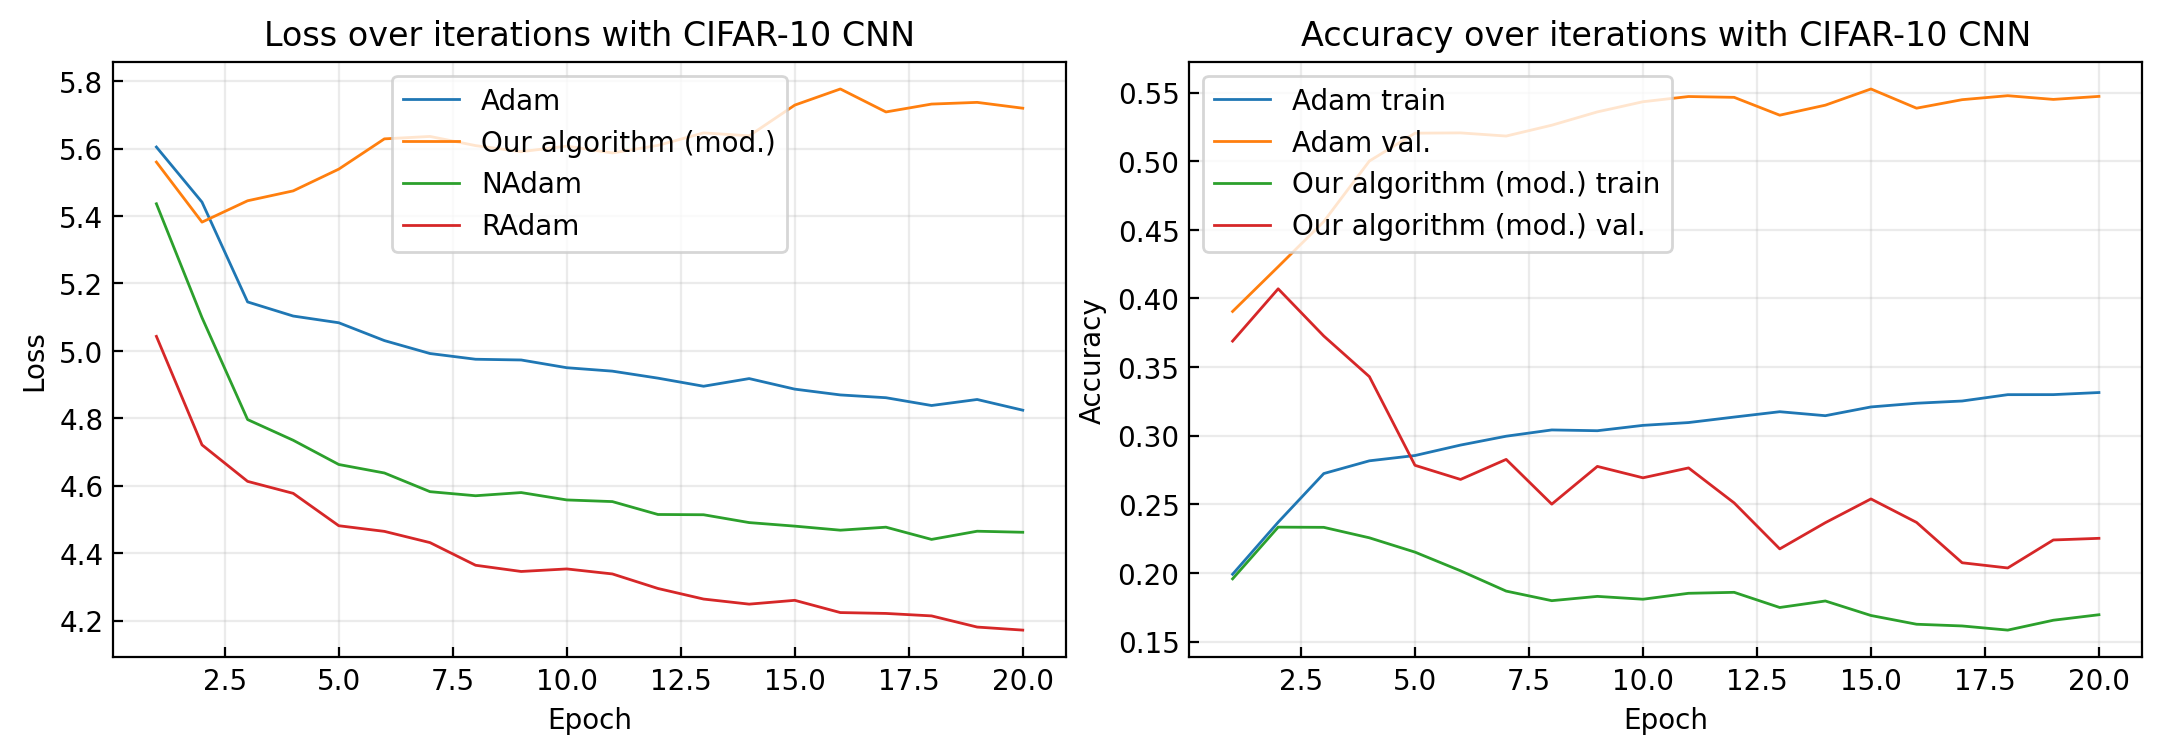

In [ ]:
plt.figure(figsize=(11, 7), dpi=200)

plt.subplot(2, 2, 1)  # (rows, columns, plot_number)
plt.plot(range(1, len(train_losses1) + 1), train_losses1, label='Adam', lw=1)
# plt.plot(range(1, len(val_losses1) + 1), val_losses1, label='Adam val.', lw=1)
plt.plot(range(1, len(train_losses2) + 1), train_losses2, label='Our algorithm (mod.)', lw=1)
plt.plot(range(1, len(train_losses3) + 1), train_losses3, label='NAdam', lw=1)
plt.plot(range(1, len(train_losses4) + 1), train_losses4, label='RAdam', lw=1)
# plt.plot(range(1, len(val_losses2) + 1), val_losses2, label='Our algorithm val.', lw=1)
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over iterations with CIFAR-10 CNN')
plt.legend()


plt.subplot(2, 2, 2)  # (rows, columns, plot_number)
plt.plot(range(1, len(train_accs1) + 1), train_accs1, label='Adam train', lw=1)
plt.plot(range(1, len(val_accs1) + 1), val_accs1, label='Adam val.', lw=1)
plt.plot(range(1, len(train_accs2) + 1), train_accs2, label='Our algorithm (mod.) train', lw=1)
plt.plot(range(1, len(val_accs2) + 1), val_accs2, label='Our algorithm (mod.) val.', lw=1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.title('Accuracy over iterations with CIFAR-10 CNN')
plt.legend()




# Show the plots
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.show()